<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
import catboost as cb

from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 

from sklearn.metrics import make_scorer, mean_squared_error 

RS=42

In [2]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0]) 

In [3]:
#Проверим в даты на хронологический порядок
df.index.is_monotonic

True

In [4]:
df.sample(5)

,num_orders
datetime,
2018-08-03 02:20:00,26
2018-07-26 22:10:00,20
2018-05-20 10:40:00,14
2018-03-07 04:20:00,8
2018-05-22 13:30:00,8


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.isna().sum()

num_orders    0
dtype: int64

In [7]:
# ресемплирование по одному часу.
df=df.resample('1H').sum()

<AxesSubplot:xlabel='datetime'>

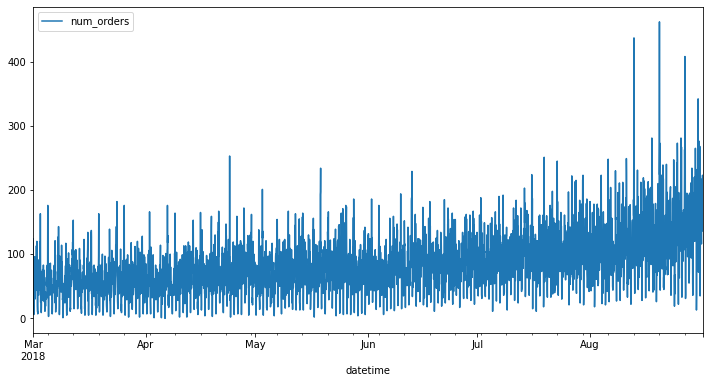

In [8]:
df.plot(figsize=(12, 6))

**Вывод по главе**

- Исходный датасет состоит из 2 столбцов: 

    -  datetime — дата и время заказа
    -  num_orders — количество заказов.

- Количество строк в датасете 26_496. 

- Данные были ресемплированы.

## Анализ

In [9]:
print('Starting date:',df.index.min())
print('Ending date:',df.index.max())
print('Total time:',df.index.max() - df.index.min())
print('////_______________________________________//////_________________________________________///')
df.describe()

Starting date: 2018-03-01 00:00:00
Ending date: 2018-08-31 23:00:00
Total time: 183 days 23:00:00
////_______________________________________//////_________________________________________///


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Данные собраны за 184 дня. Минимальное количество заказов за 1 час -  0, а максимальное -119.

<AxesSubplot:xlabel='datetime'>

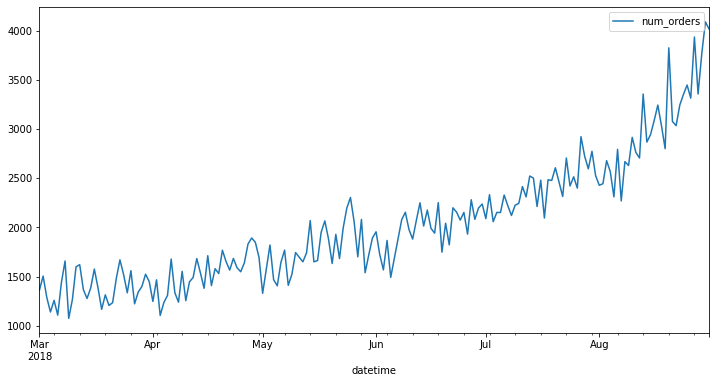

In [10]:
 #график вызовов по дням
df.resample('1D').sum().plot(figsize=(12, 6))    

<AxesSubplot:xlabel='datetime'>

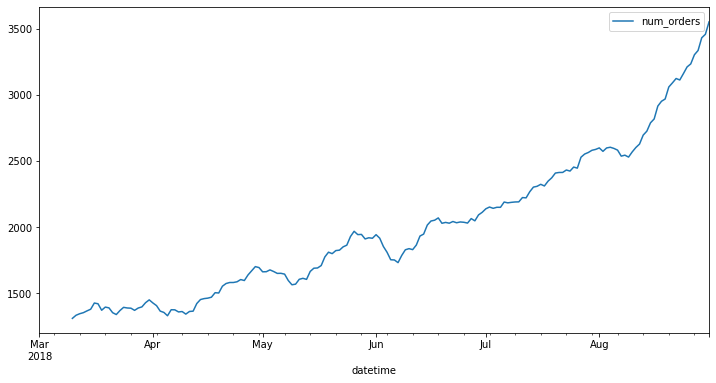

In [11]:
#скользящая средняя 10
df.resample('1D').sum().rolling(10).mean().plot(figsize=(12, 6))

Виден восхдящий тренд 

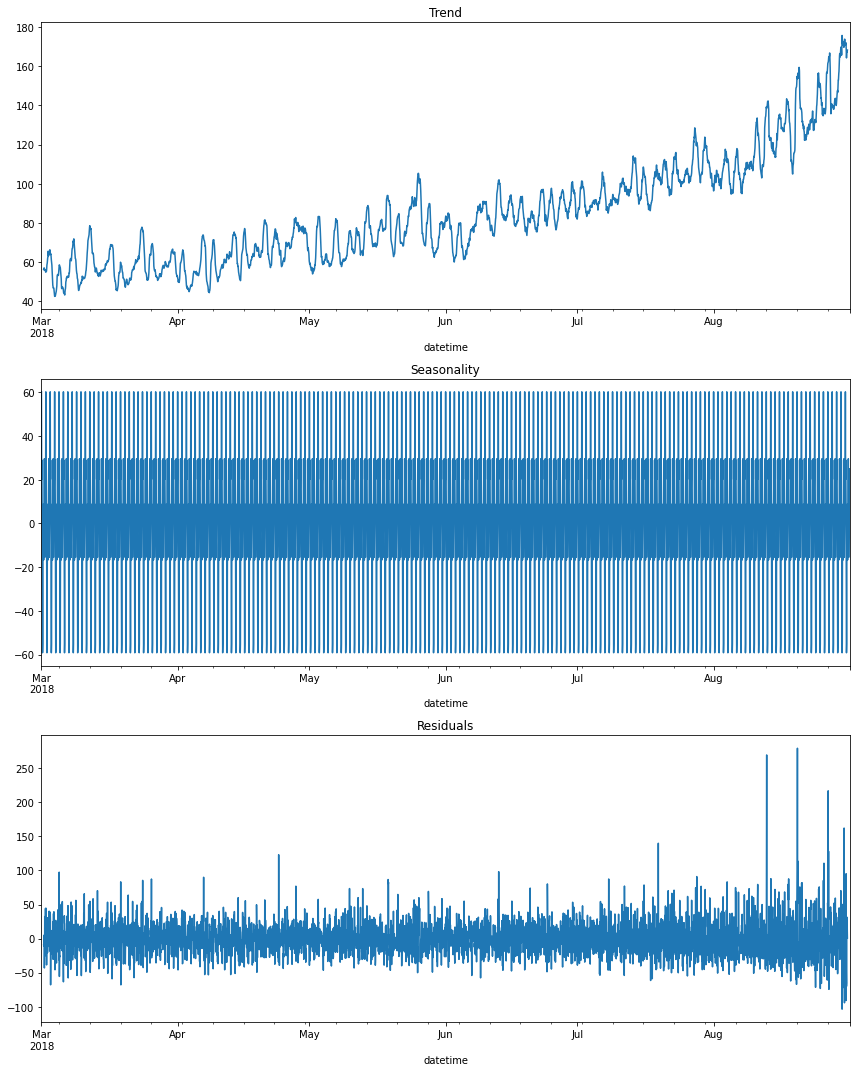

In [12]:
# Анализ временного ряда
decomposed = seasonal_decompose(df)

plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Residuals')
plt.tight_layout()

Не очень информативная картинка

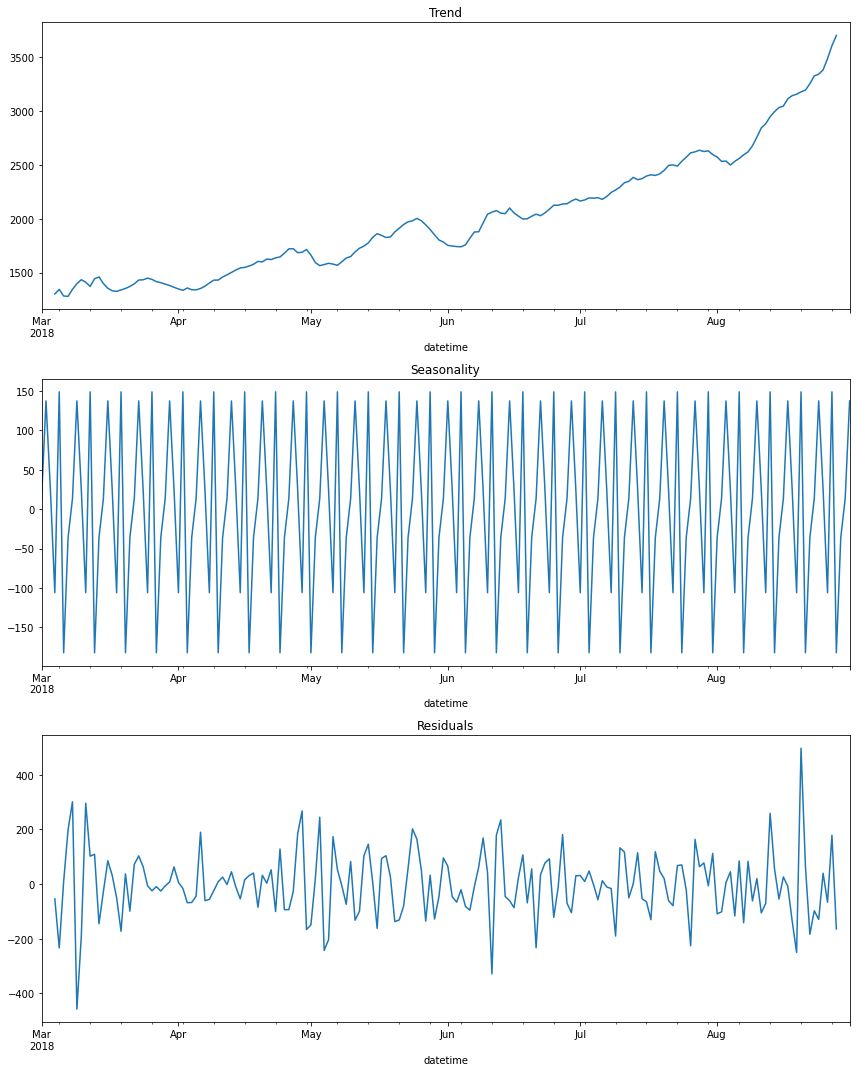

In [13]:
# Анализ временного ряда с семплированием до 1 дня
decomposed = seasonal_decompose(df.resample('1D').sum())

plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='dayofweek'>

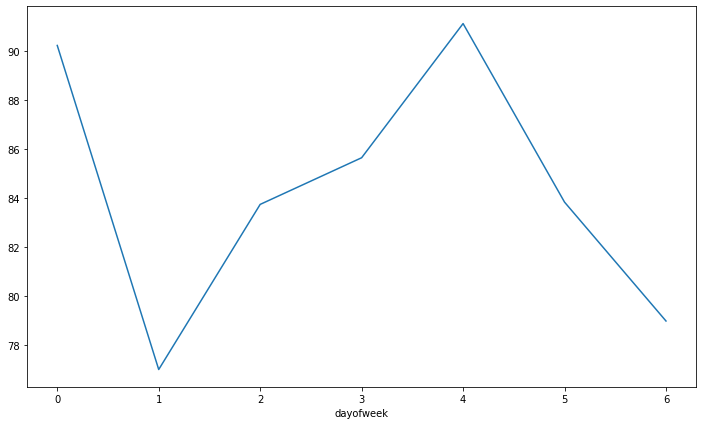

In [14]:
dw=df.copy()
dw['dayofweek'] = dw.index.dayofweek
dw.groupby('dayofweek')['num_orders'].mean().plot(figsize=(12, 7))

На графике отчетливо видна зависитмость количества заказов от дня недели. Активно пользуются такси в начале и конце рабочей недели. В выходные количество заказов идет на спад.

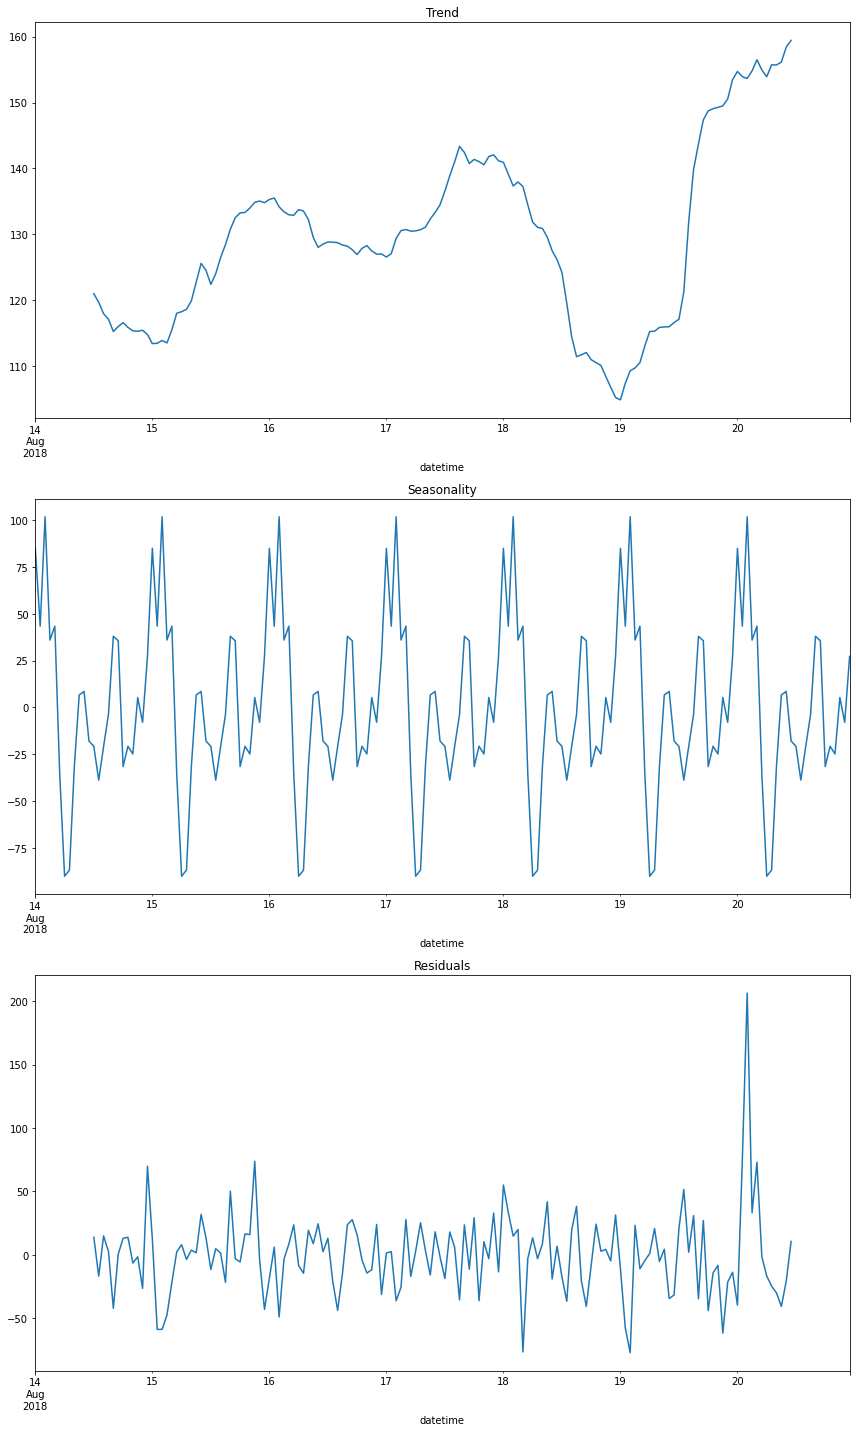

In [15]:
#Посмотрим данные за неделю

decomposed = seasonal_decompose(df['2018-08-14':'2018-08-20'].resample('1H').sum())

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Аналогичной зависимости не видно.

**Вывод по Главе**


 - Выявлен тренд на общее увеличение заказов такси
 - Существует зависитмость количества заказов от дня недели

## Обучение

В качестве моделей используем Линейную регрессию, Случайный лес и CatBoostRegressor.

In [16]:
# Используем функцию для создания признаков,которая была написана в курсе
def make_features(dt, max_lag, rolling_mean_size):
    data = dt.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()
    return data

In [17]:
#Применим функцию с лагом до 24 часов и 100-м скользящим средним:
df = make_features(df, 24, 100)

In [18]:
df = df.dropna()

In [19]:
df.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,2018,3,5,0,51.0,32.0,176.0,86.0,68.0,...,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,56.46
2018-03-05 05:00:00,16,2018,3,5,0,34.0,51.0,32.0,176.0,86.0,...,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,55.56
2018-03-05 06:00:00,3,2018,3,5,0,16.0,34.0,51.0,32.0,176.0,...,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,54.87
2018-03-05 07:00:00,14,2018,3,5,0,3.0,16.0,34.0,51.0,32.0,...,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,54.19
2018-03-05 08:00:00,31,2018,3,5,0,14.0,3.0,16.0,34.0,51.0,...,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,53.67


In [20]:
#Поделим данные на фичи и таргеты,  а также на train и test:
train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state = RS)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

print(features_train.shape[0]/df.shape[0], features_test.shape[0]/df.shape[0])
print(target_train.shape[0]/df.shape[0], target_test.shape[0]/df.shape[0])

0.8999073215940686 0.10009267840593142
0.8999073215940686 0.10009267840593142


In [21]:
# создадим RMSE score 
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5

RMSE_score = make_scorer(RMSE, greater_is_better=False)

**Линейная регрессия**

In [22]:
%%time
r_cv = TimeSeriesSplit(n_splits=3).split(features_train)
reg = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
reg.fit(features_train, target_train)
r_cv_score = pd.Series(cross_val_score(reg,features_train,target_train,scoring=RMSE_score,cv=r_cv)).mean()*(-1)
print('RMSE линейной регрессии на кросс-валидации:', r_cv_score)

RMSE линейной регрессии на кросс-валидации: 28.275898753655373
CPU times: user 287 ms, sys: 333 ms, total: 619 ms
Wall time: 561 ms


**Random forest**

In [23]:
%%time
f_cv = TimeSeriesSplit(n_splits=3).split(features_train)
rf = RandomForestRegressor()
#Определяю словарь с набором параметров
f_params = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }

#Применяю GridSearchCV с кросс-валидацией
f_grid = GridSearchCV(rf, f_params, scoring=RMSE_score, cv=f_cv)
f_grid.fit(features_train, target_train)

CPU times: user 4min 7s, sys: 637 ms, total: 4min 8s
Wall time: 4min 8s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f3967a7c200>,
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 15, 2),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 8, 2),
                         'n_estimators': range(5, 30, 5)},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [24]:
%%time

f_params = f_grid.best_params_
f_score = f_grid.score(features_train, target_train) * (-1)
print(f_params)
print(f_score)

{'max_depth': 13, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 25}
13.233039167199875
CPU times: user 22.3 ms, sys: 0 ns, total: 22.3 ms
Wall time: 39 ms


**CatBoost**

In [25]:
%%time

c_cv = TimeSeriesSplit(n_splits=3).split(features_train)
cat = cb.CatBoostRegressor()
#Определяю словарь с набором параметров
c_params = {'learning_rate': [0.03, 0.1, 0.2],
                'depth': [4, 6, 10]
               }
c_grid = GridSearchCV(cat, c_params, scoring=RMSE_score, cv=c_cv)
c_grid.fit(features_train, target_train, verbose=100)

0:	learn: 28.8547429	total: 54.8ms	remaining: 54.8s
100:	learn: 18.1994024	total: 204ms	remaining: 1.82s
200:	learn: 16.2825116	total: 356ms	remaining: 1.41s
300:	learn: 15.0781771	total: 509ms	remaining: 1.18s
400:	learn: 13.9105862	total: 662ms	remaining: 989ms
500:	learn: 12.8555891	total: 814ms	remaining: 810ms
600:	learn: 11.9949258	total: 978ms	remaining: 649ms
700:	learn: 11.1144727	total: 1.13s	remaining: 481ms
800:	learn: 10.4435977	total: 1.28s	remaining: 318ms
900:	learn: 9.8094890	total: 1.43s	remaining: 157ms
999:	learn: 9.2428678	total: 1.58s	remaining: 0us
0:	learn: 31.8971050	total: 2.65ms	remaining: 2.65s
100:	learn: 20.4293611	total: 189ms	remaining: 1.68s
200:	learn: 18.7120777	total: 377ms	remaining: 1.5s
300:	learn: 17.5993542	total: 585ms	remaining: 1.36s
400:	learn: 16.7013235	total: 781ms	remaining: 1.17s
500:	learn: 15.9508179	total: 1.03s	remaining: 1.03s
600:	learn: 15.2953652	total: 1.25s	remaining: 832ms
700:	learn: 14.6979112	total: 1.45s	remaining: 617ms


300:	learn: 11.7840734	total: 1.51s	remaining: 3.51s
400:	learn: 9.9582603	total: 2.01s	remaining: 3s
500:	learn: 8.5639468	total: 2.49s	remaining: 2.48s
600:	learn: 7.4369242	total: 2.97s	remaining: 1.97s
700:	learn: 6.4845858	total: 3.45s	remaining: 1.47s
800:	learn: 5.5989653	total: 3.94s	remaining: 979ms
900:	learn: 4.9209332	total: 4.44s	remaining: 488ms
999:	learn: 4.2872083	total: 4.99s	remaining: 0us
0:	learn: 27.0307801	total: 3.91ms	remaining: 3.9s
100:	learn: 7.4456430	total: 356ms	remaining: 3.17s
200:	learn: 3.6130418	total: 711ms	remaining: 2.83s
300:	learn: 1.9342398	total: 1.07s	remaining: 2.49s
400:	learn: 1.0889913	total: 1.5s	remaining: 2.24s
500:	learn: 0.5764671	total: 1.86s	remaining: 1.85s
600:	learn: 0.3023099	total: 2.21s	remaining: 1.47s
700:	learn: 0.1609952	total: 2.56s	remaining: 1.09s
800:	learn: 0.0805689	total: 2.94s	remaining: 730ms
900:	learn: 0.0442068	total: 3.3s	remaining: 363ms
999:	learn: 0.0236857	total: 3.65s	remaining: 0us
0:	learn: 29.3855918	

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f3967c80e40>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f3967d451f0>,
             param_grid={'depth': [4, 6, 10],
                         'learning_rate': [0.03, 0.1, 0.2]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [26]:
%%time

c_params = c_grid.best_params_
c_score = c_grid.score(features_train, target_train) * (-1)
print(c_params)
print(c_score)

{'depth': 6, 'learning_rate': 0.03}
14.329875490541367
CPU times: user 5.6 ms, sys: 3.95 ms, total: 9.54 ms
Wall time: 7.2 ms


## Тестирование

In [27]:
lin_array =    [r_cv_score]
forest_array = [f_score]
cat_array =    [c_score]

rezult={'Линейная регрессия':np.array(lin_array), 'Случайный лес':np.array(forest_array), 
        'CatBoost':np.array(cat_array)}
rezult_df=pd.DataFrame(rezult,index=['rmse'])


In [28]:
rezult_df

,Линейная регрессия,Случайный лес,CatBoost
rmse,28.275899,13.233039,14.329875


**Лучшей моделью оказался случайный лес**

In [29]:
%%time

#Протестируем модель на оптимальных гиперпараметрах

forest_model = RandomForestRegressor(random_state=RS,
                                     max_depth=f_params['max_depth'],
                                     min_samples_leaf = f_params['min_samples_leaf'],
                                     min_samples_split = f_params['min_samples_split'],
                                     n_estimators = f_params['n_estimators'])

forest_model.fit(features_train, target_train)
forest_model_predictions = forest_model.predict(features_test)
forest_RMSE = round(RMSE(target_test, forest_model_predictions), 3)
print('RMSE модели Случайного леса на тесте:', forest_RMSE)

RMSE модели Случайного леса на тесте: 43.418
CPU times: user 1.08 s, sys: 0 ns, total: 1.08 s
Wall time: 1.08 s


In [30]:
# %%time

# #Обучаю модель на оптимальных гиперпараметрах
# model_cat = cb.CatBoostRegressor(learning_rate=c_params['learning_rate'],
#                                 depth=c_params['depth'])

# model_cat.fit(features_train, target_train, verbose=100)
# model_cat_pred = model_cat.predict(features_test)

# #Определяю метрику RMSE
# cat_RMSE = round(RMSE(target_test, model_cat_pred), 3)
# print('RMSE модели CatBoostRegressor:', cat_RMSE)

In [31]:
%%time
forest_model.fit(features_train, target_train)
f_imp = pd.Series(forest_model.feature_importances_, features_train.columns)

CPU times: user 1.06 s, sys: 4.01 ms, total: 1.06 s
Wall time: 1.06 s


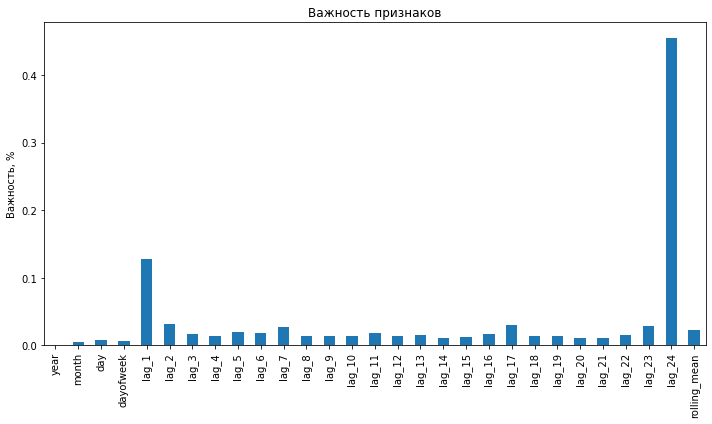

In [32]:
fig, ax = plt.subplots(figsize=(10,6))
f_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

In [40]:
pred = pd.Series(forest_model_predictions)

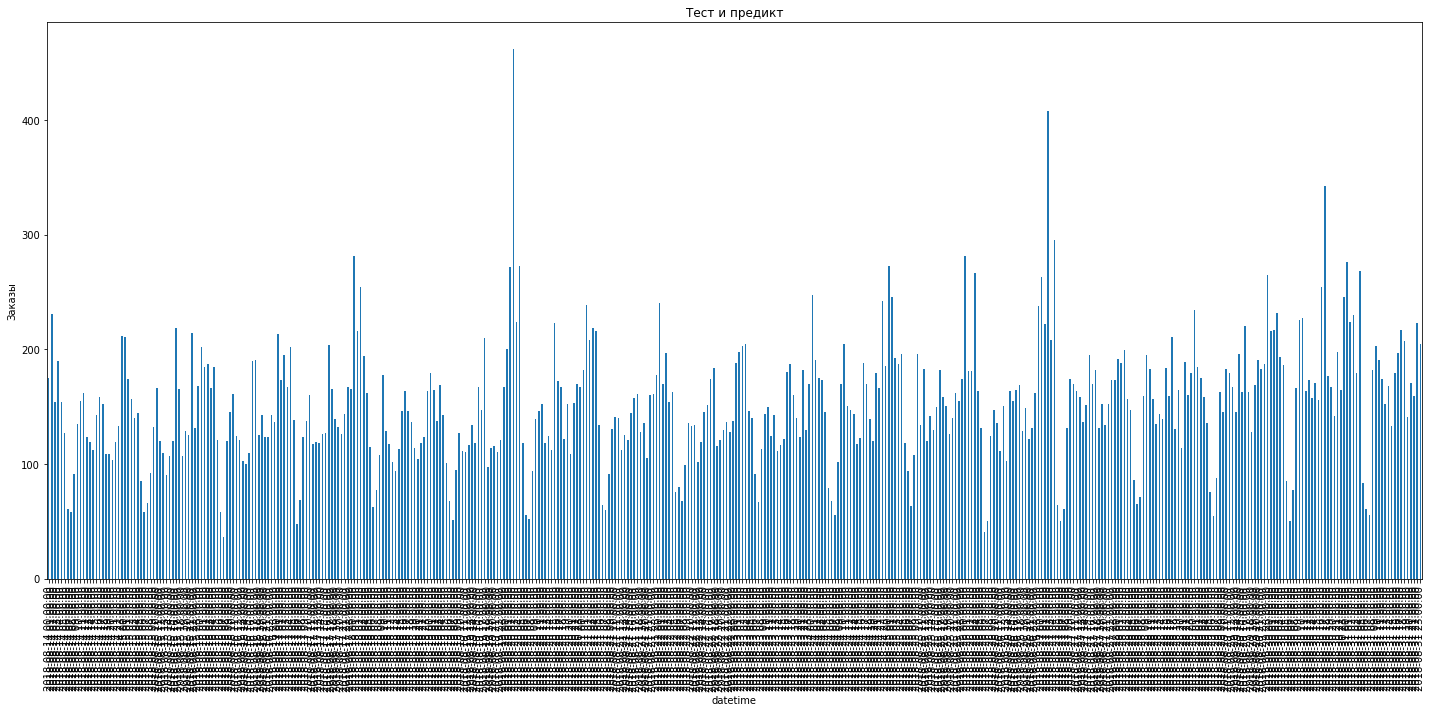

In [42]:
fig, ax = plt.subplots(figsize=(20,10))
ax= pred.plot.bar()
target_test.plot.bar(ax=ax, )
ax.set_title("Тест и предикт")
ax.set_ylabel('Заказы')
fig.tight_layout()




**Вывод**

Лучшей моделью оказался случайный лес. Значение метрики RMSE на тестовой выборке меньше 48.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48